📦 Loading data...
Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
🔍 Extracting VGG19 features...
13/13 [==============================] - 22s 2s/step
📉 Applying PCA...


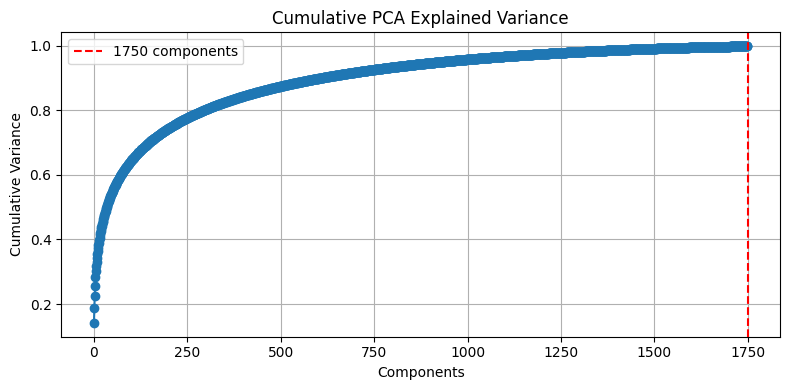


🔧 Training SVM with kernel = 'linear'

✅ Validation Accuracy (linear): 0.7500
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       200
           1       0.73      0.80      0.76       200

    accuracy                           0.75       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.75      0.75       400



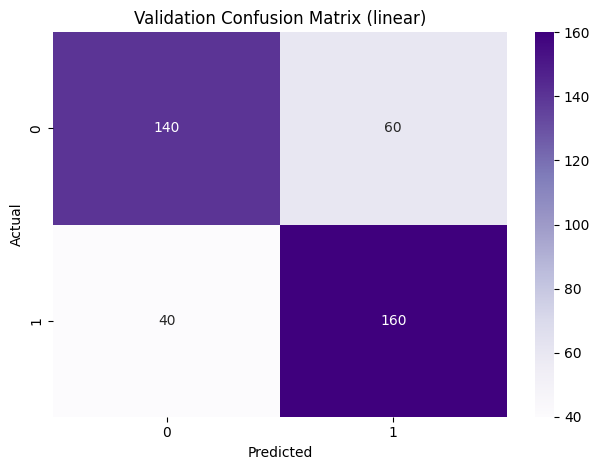

🧪 Test Accuracy (linear): 0.7125
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       200
           1       0.70      0.76      0.72       200

    accuracy                           0.71       400
   macro avg       0.71      0.71      0.71       400
weighted avg       0.71      0.71      0.71       400



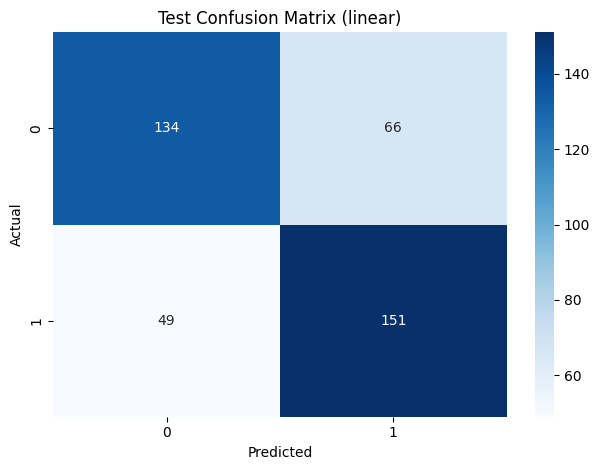

————————————————————————————————————————————————————————————

🔧 Training SVM with kernel = 'poly'

✅ Validation Accuracy (poly): 0.6600
              precision    recall  f1-score   support

           0       1.00      0.32      0.48       200
           1       0.60      1.00      0.75       200

    accuracy                           0.66       400
   macro avg       0.80      0.66      0.62       400
weighted avg       0.80      0.66      0.62       400



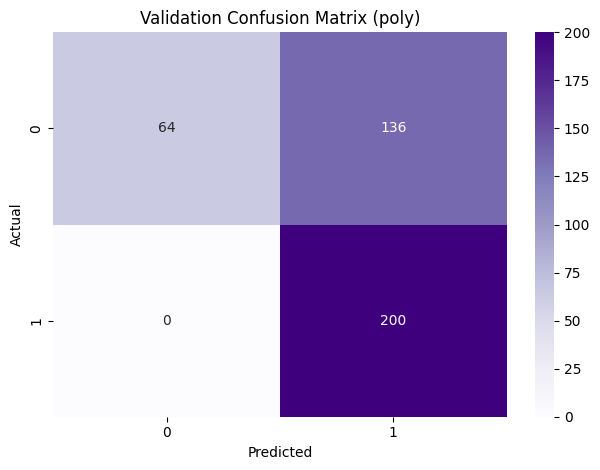

🧪 Test Accuracy (poly): 0.6000
              precision    recall  f1-score   support

           0       0.98      0.20      0.34       200
           1       0.56      0.99      0.71       200

    accuracy                           0.60       400
   macro avg       0.77      0.60      0.53       400
weighted avg       0.77      0.60      0.53       400



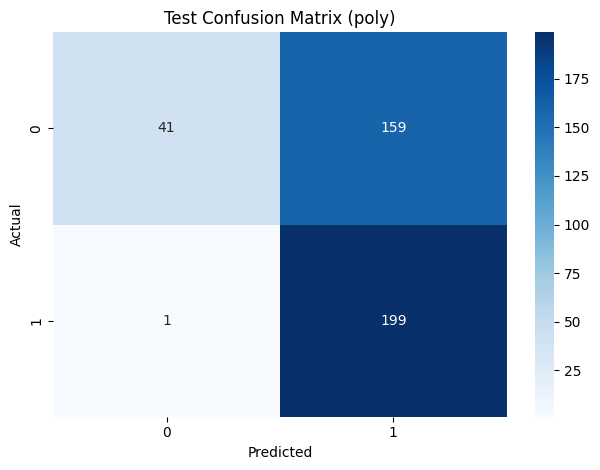

————————————————————————————————————————————————————————————

🔧 Training SVM with kernel = 'rbf'

✅ Validation Accuracy (rbf): 0.7375
              precision    recall  f1-score   support

           0       0.82      0.60      0.70       200
           1       0.69      0.87      0.77       200

    accuracy                           0.74       400
   macro avg       0.76      0.74      0.73       400
weighted avg       0.76      0.74      0.73       400



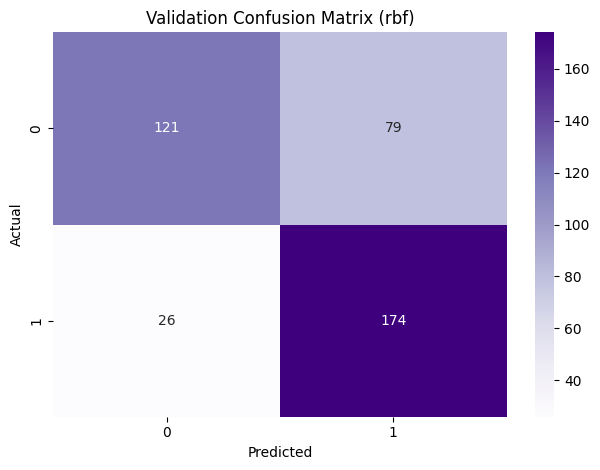

🧪 Test Accuracy (rbf): 0.7400
              precision    recall  f1-score   support

           0       0.83      0.60      0.70       200
           1       0.69      0.88      0.77       200

    accuracy                           0.74       400
   macro avg       0.76      0.74      0.74       400
weighted avg       0.76      0.74      0.74       400



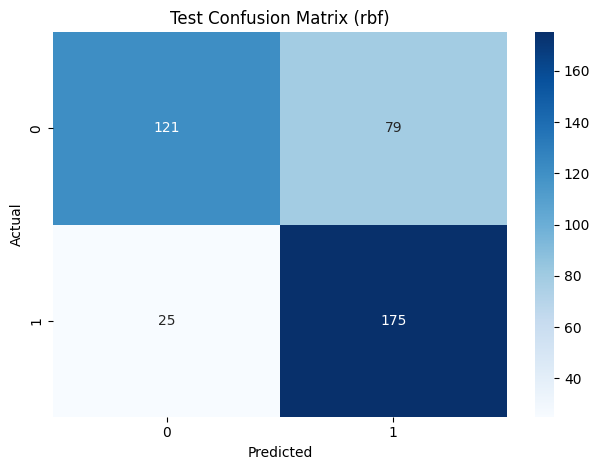

————————————————————————————————————————————————————————————

🔧 Training SVM with kernel = 'sigmoid'

✅ Validation Accuracy (sigmoid): 0.7150
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       200
           1       0.70      0.74      0.72       200

    accuracy                           0.71       400
   macro avg       0.72      0.71      0.71       400
weighted avg       0.72      0.71      0.71       400



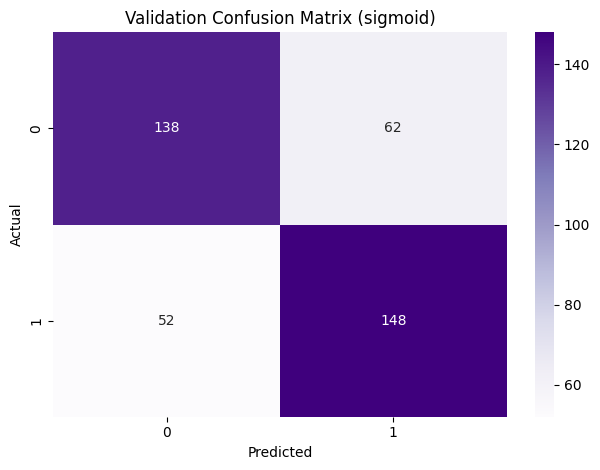

🧪 Test Accuracy (sigmoid): 0.6975
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       200
           1       0.69      0.72      0.70       200

    accuracy                           0.70       400
   macro avg       0.70      0.70      0.70       400
weighted avg       0.70      0.70      0.70       400



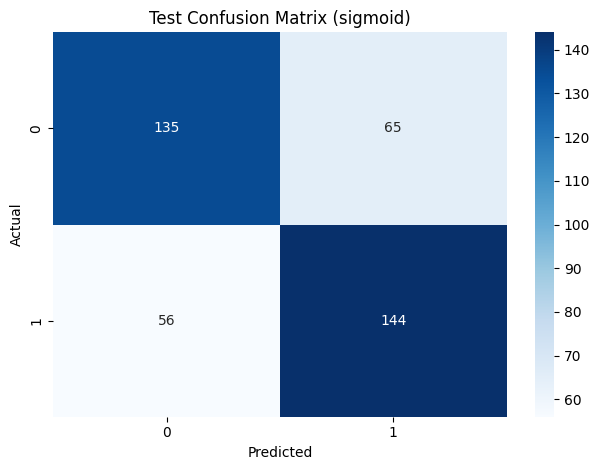

————————————————————————————————————————————————————————————

📊 SVM Kernel Comparison Summary
Kernel     Validation Acc  Test Acc  
linear     0.7500          0.7125    
poly       0.6600          0.6000    
rbf        0.7375          0.7400    
sigmoid    0.7150          0.6975    


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Constants ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = "dataset"
RANDOM_STATE = 42
PCA_COMPONENTS = 1750

# === Step 1: Load Image Data ===
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def load_data(split):
    return datagen.flow_from_directory(
        os.path.join(DATASET_PATH, split),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

print("📦 Loading data...")
train_gen = load_data("train")
val_gen = load_data("validation")
test_gen = load_data("test")

# === Step 2: Feature Extraction via VGG19 ===
print("🔍 Extracting VGG19 features...")
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg.trainable = False

def extract_features(generator):
    features = vgg.predict(generator, verbose=1)
    return features.reshape(features.shape[0], -1), generator.classes

X_train, y_train = extract_features(train_gen)
X_val, y_val = extract_features(val_gen)
X_test, y_test = extract_features(test_gen)

X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_STATE)

# === Step 3: PCA ===
print("📉 Applying PCA...")
pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# 📊 PCA Variance Plot
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axvline(PCA_COMPONENTS, color='red', linestyle='--', label=f"{PCA_COMPONENTS} components")
plt.title("Cumulative PCA Explained Variance")
plt.xlabel("Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Step 4: Train & Evaluate Each SVM Kernel ===
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svm_results = []

for kernel in kernels:
    print(f"\n🔧 Training SVM with kernel = '{kernel}'")
    
    model = make_pipeline(
        StandardScaler(),
        SVC(kernel=kernel, C=10.0, gamma='scale', class_weight='balanced', random_state=RANDOM_STATE)
    )
    
    model.fit(X_train_pca, y_train)

    # Validation
    y_val_pred = model.predict(X_val_pca)
    val_acc = accuracy_score(y_val, y_val_pred)

    # Test
    y_test_pred = model.predict(X_test_pca)
    test_acc = accuracy_score(y_test, y_test_pred)

    svm_results.append({
        'kernel': kernel,
        'val_acc': val_acc,
        'test_acc': test_acc
    })

    # === Validation Report ===
    print(f"\n✅ Validation Accuracy ({kernel}): {val_acc:.4f}")
    print(classification_report(y_val, y_val_pred))
    sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='Purples')
    plt.title(f"Validation Confusion Matrix ({kernel})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # === Test Report ===
    print(f"🧪 Test Accuracy ({kernel}): {test_acc:.4f}")
    print(classification_report(y_test, y_test_pred))
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Test Confusion Matrix ({kernel})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    print("—" * 60)

# === Final Summary Table ===
print("\n📊 SVM Kernel Comparison Summary")
print(f"{'Kernel':<10} {'Validation Acc':<15} {'Test Acc':<10}")
for res in svm_results:
    print(f"{res['kernel']:<10} {res['val_acc']:<15.4f} {res['test_acc']:<10.4f}")
